# Visualize Training Segments

This notebook visualizes one training segment for each class in the dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path

# Add project root to path to allow imports from src
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.utils.config import AppConfig

config = AppConfig()

In [2]:
# Load data
X_train = np.load(config.data_dir / "X_train.npy")
Y_train = np.load(config.data_dir / "Y_train.npy")

label_names = config.label_names
print("Loaded training data:", X_train.shape, Y_train.shape)
print("Labels:", label_names)

Loaded training data: (210, 256, 4) (210, 256)
Labels: {0: 'None', 1: 'Bearish Normal', 2: 'Bearish Wedge', 3: 'Bearish Pennant', 4: 'Bullish Normal', 5: 'Bullish Wedge', 6: 'Bullish Pennant'}


In [3]:
def plot_segment(x, y_seq, label_name):
    """Plots a single segment's OHLC close price and its sequence labels."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot Price (Using Close price at index 3)
    # Features: 0:Open, 1:High, 2:Low, 3:Close
    ax1.plot(x[:, 3], label='Close', color='black', linewidth=1)
    # ax1.plot(x[:, 0], label='Open', alpha=0.5)
    ax1.set_title(f"Class Example: {label_name}")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot sequence labels
    ax2.plot(y_seq, label='Label', color='red', drawstyle='steps-post')
    ax2.set_ylabel("Class ID")
    ax2.set_xlabel("Timestep")
    # Set y-ticks to show integer class IDs
    # ax2.set_yticks(sorted(label_names.keys()))
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Finding example for Class 0: None


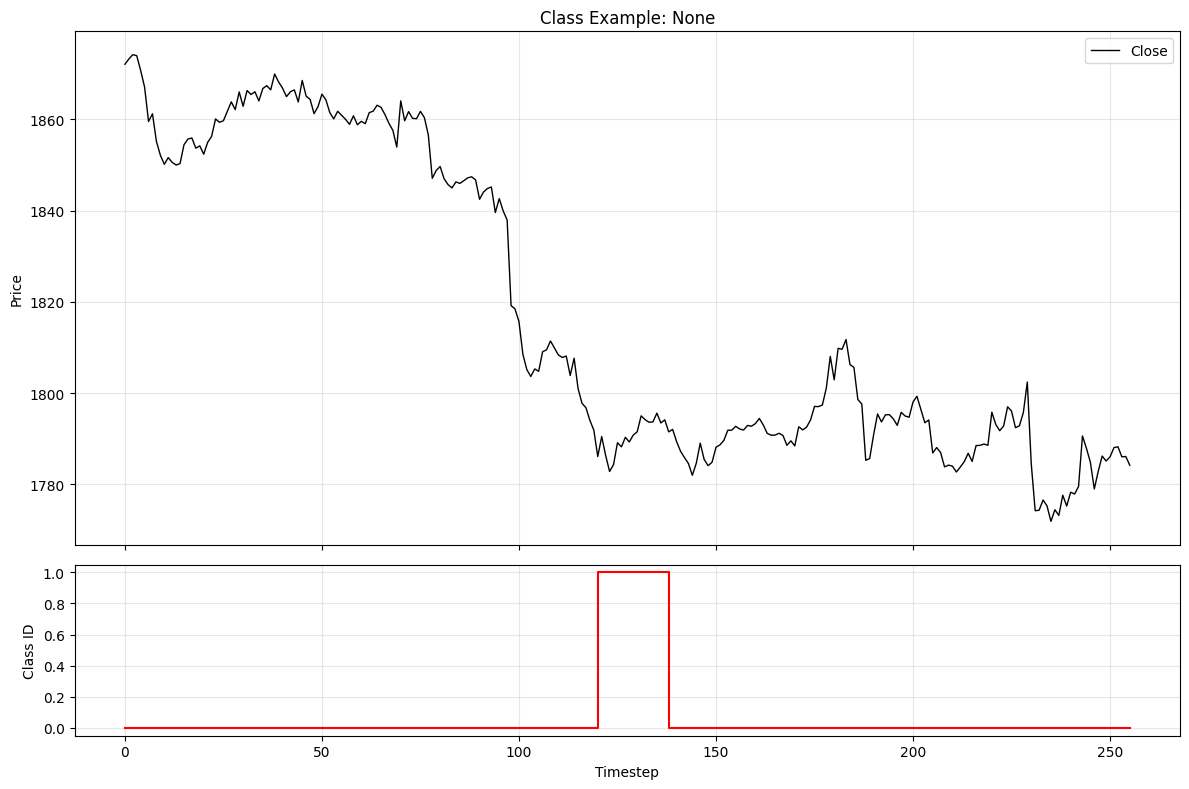


Finding example for Class 1: Bearish Normal


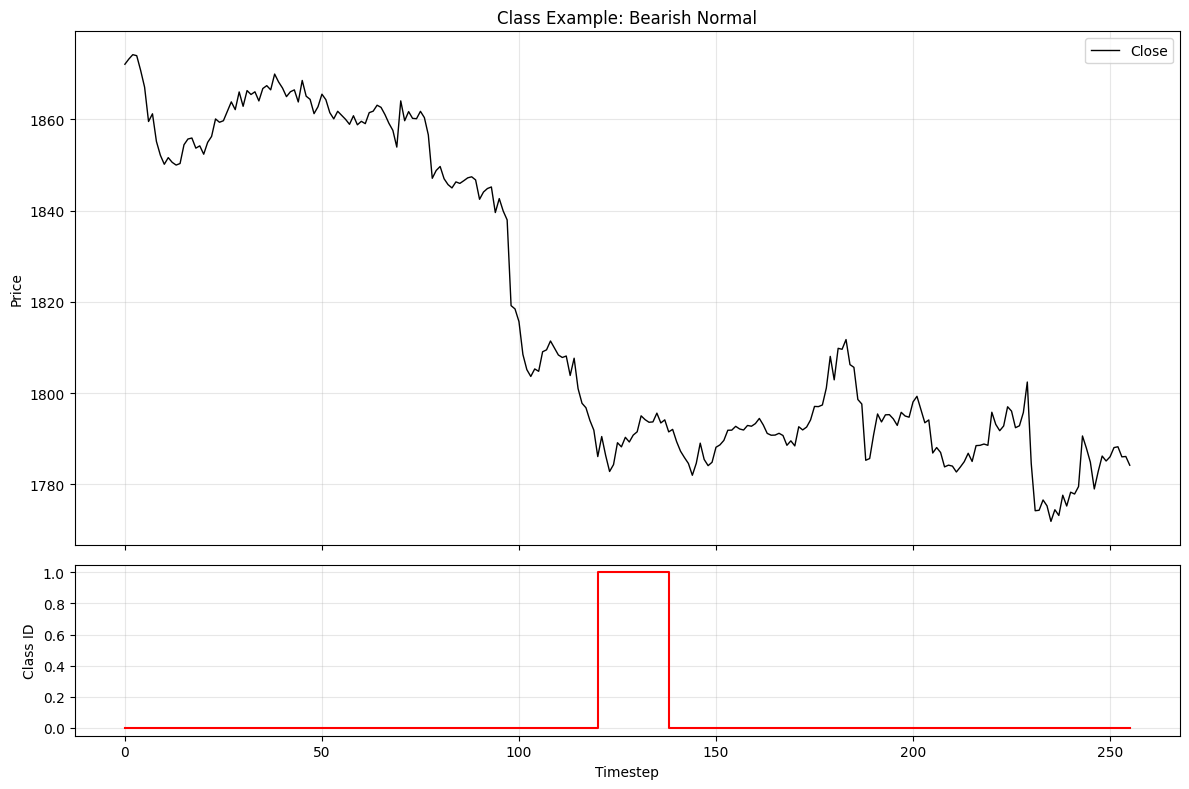


Finding example for Class 2: Bearish Wedge


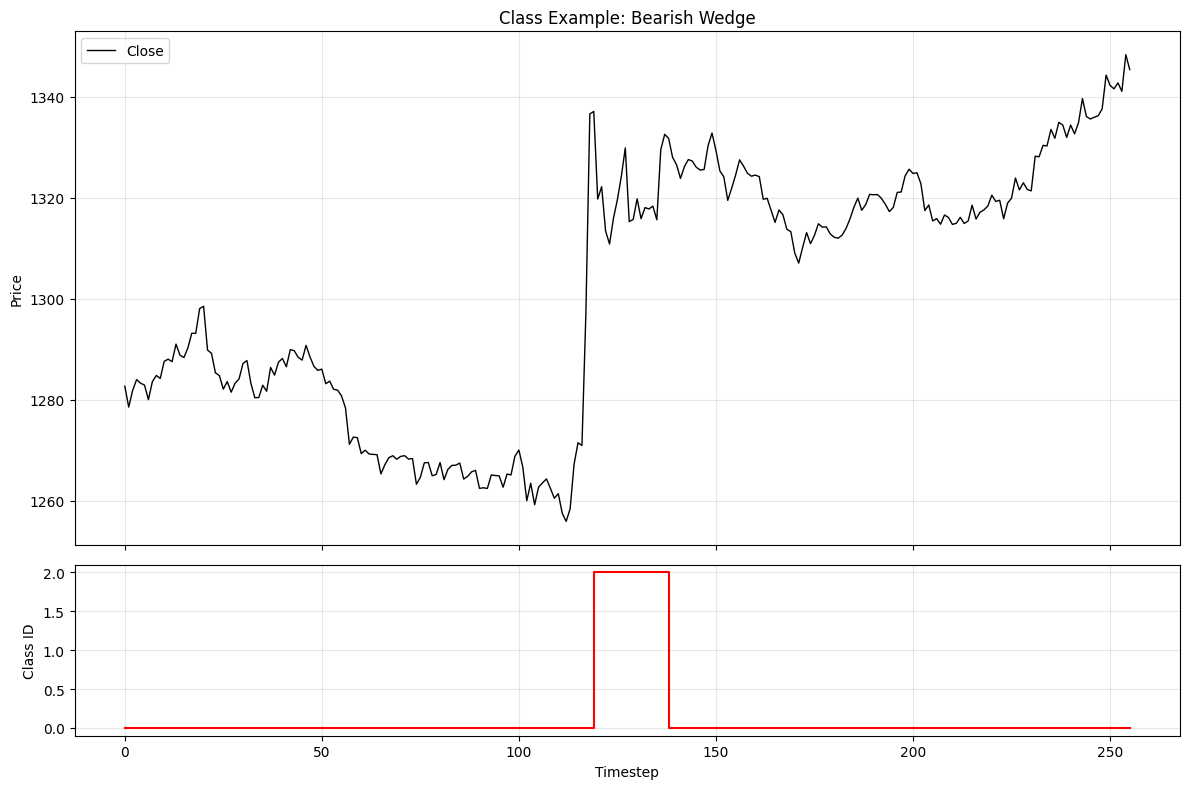


Finding example for Class 3: Bearish Pennant


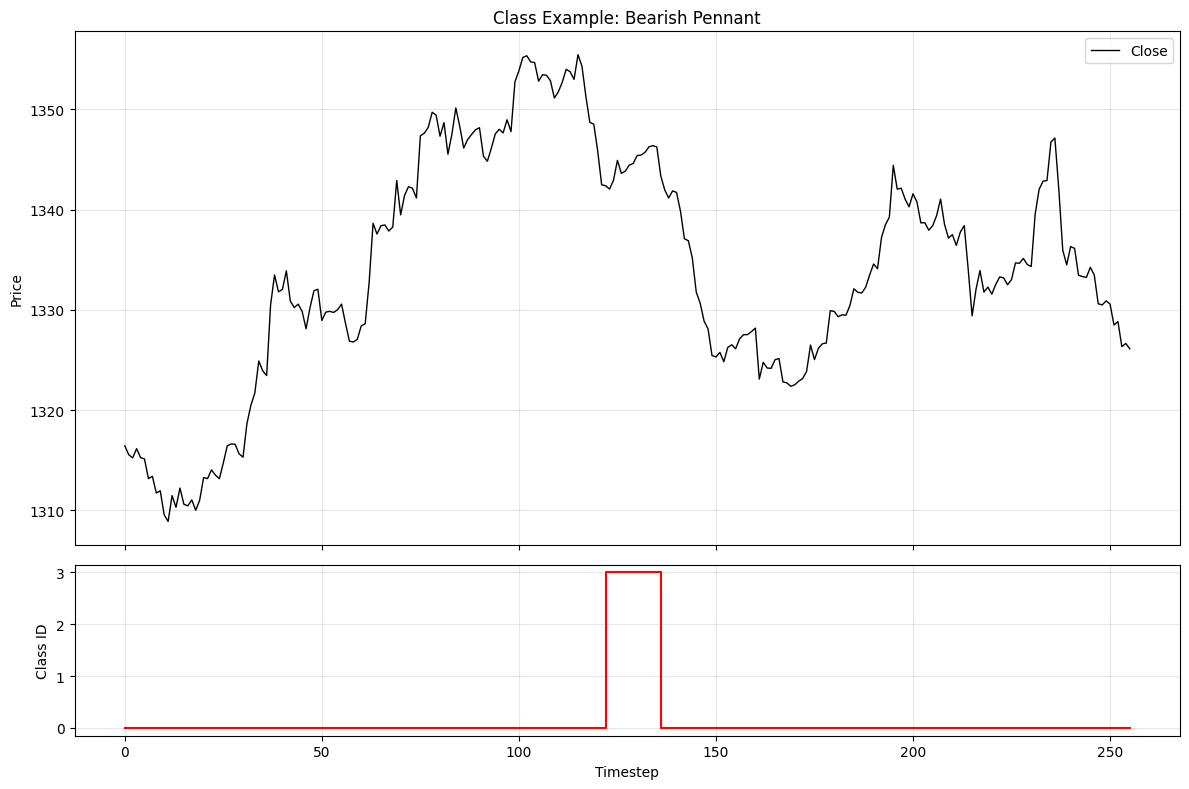


Finding example for Class 4: Bullish Normal


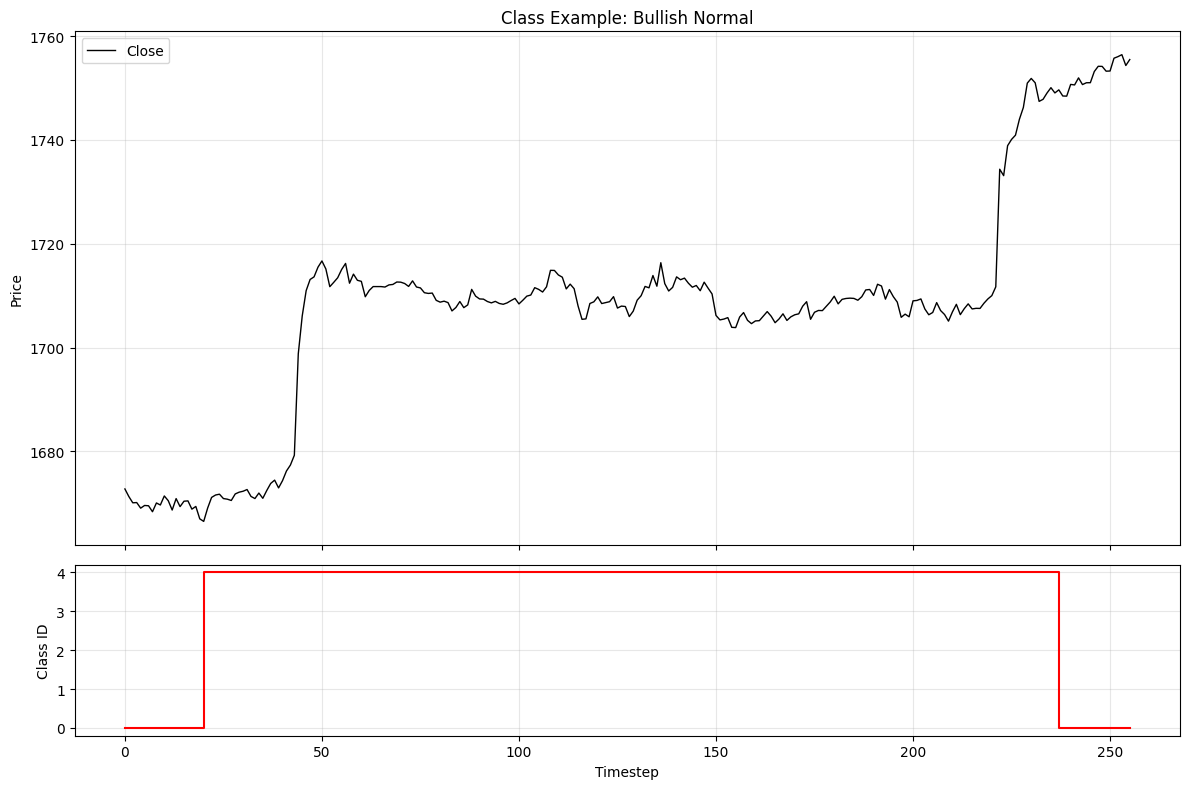


Finding example for Class 5: Bullish Wedge


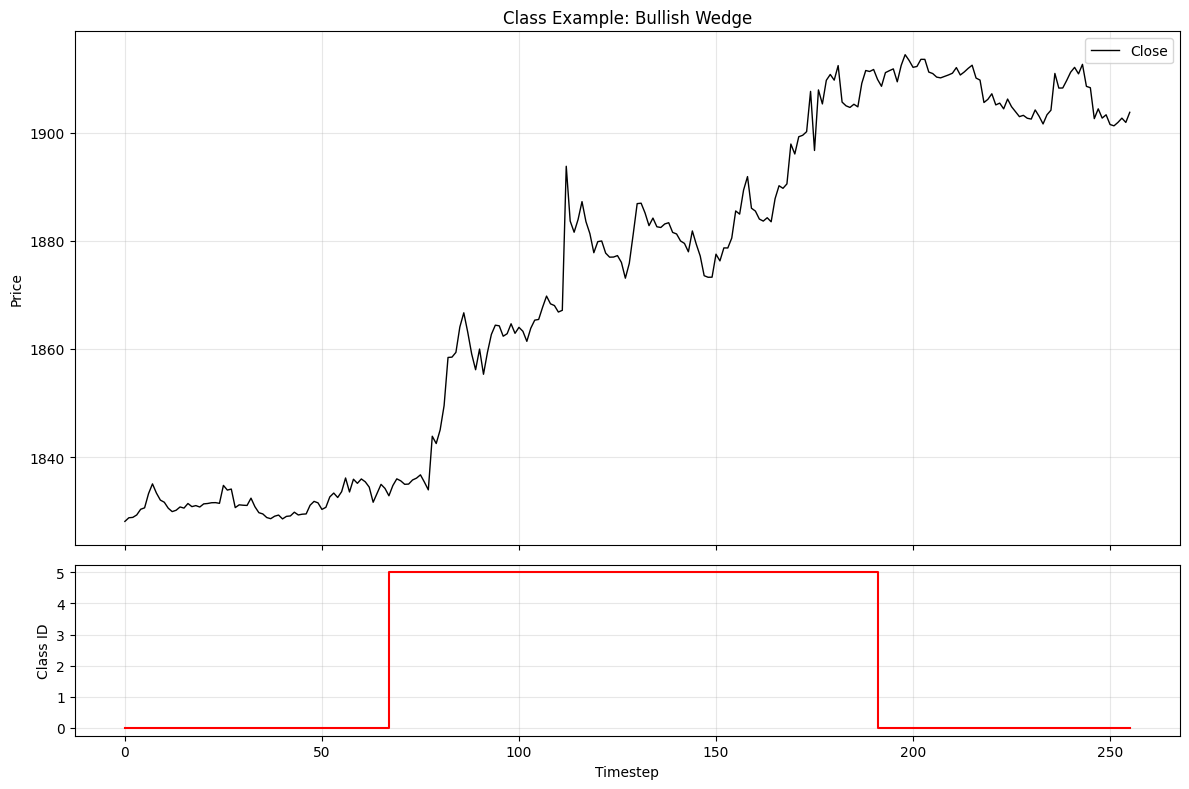


Finding example for Class 6: Bullish Pennant


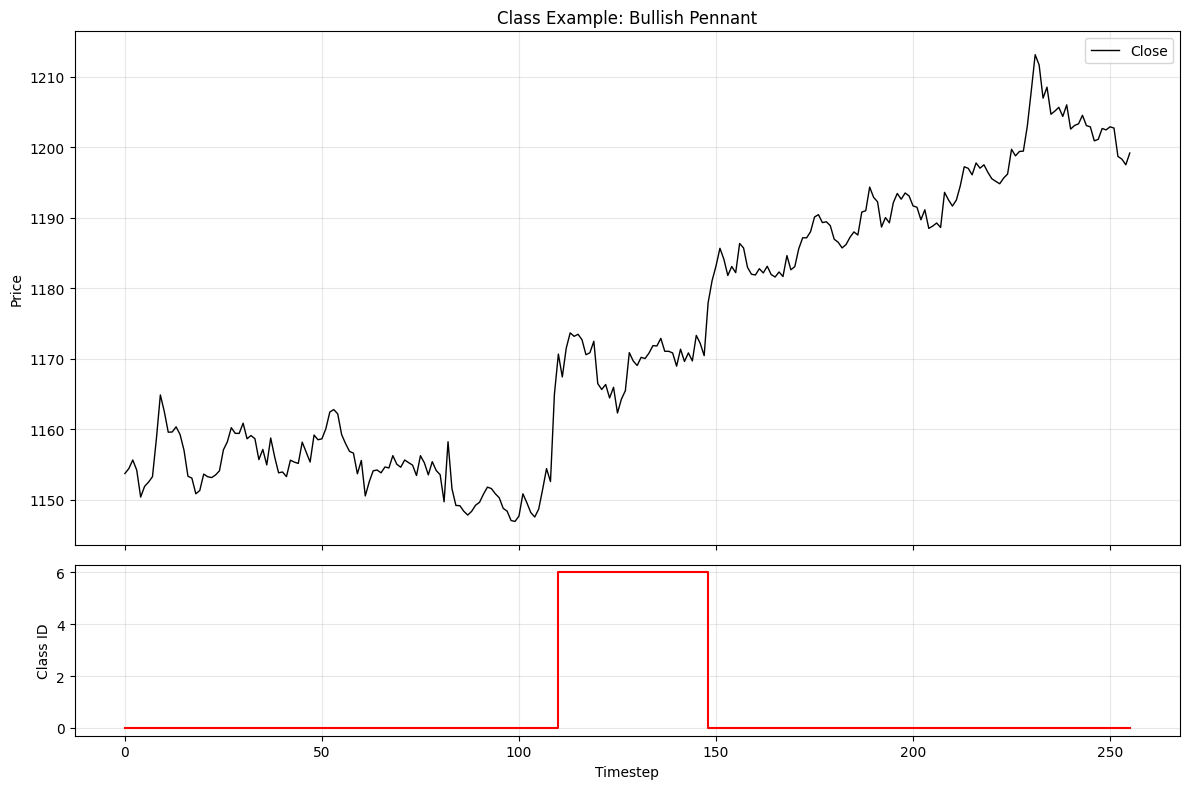

In [4]:
# Find and plot one example for each class
unique_classes = sorted(label_names.keys())

for cls_id in unique_classes:
    print(f"\nFinding example for Class {cls_id}: {label_names[cls_id]}")
    
    found = False
    for i in range(len(Y_train)):
        # Check if this class is present in the sequence
        if cls_id in Y_train[i]:
            # Filter logic to find a "good" example
            if cls_id == 0:
                # For background (0), any sequence works, but maybe pick one that is pure background if possible
                # or just the first one we find.
                plot_segment(X_train[i], Y_train[i], label_names[cls_id])
                found = True
                break
            else:
                # For patterns, ensure it's not just a single blip (noise)
                # Look for at least 10 consecutive timesteps or total timesteps
                if np.sum(Y_train[i] == cls_id) > 10:
                    plot_segment(X_train[i], Y_train[i], label_names[cls_id])
                    found = True
                    break
    
    if not found:
        print(f"No suitable example found for class {cls_id} in the training set.")

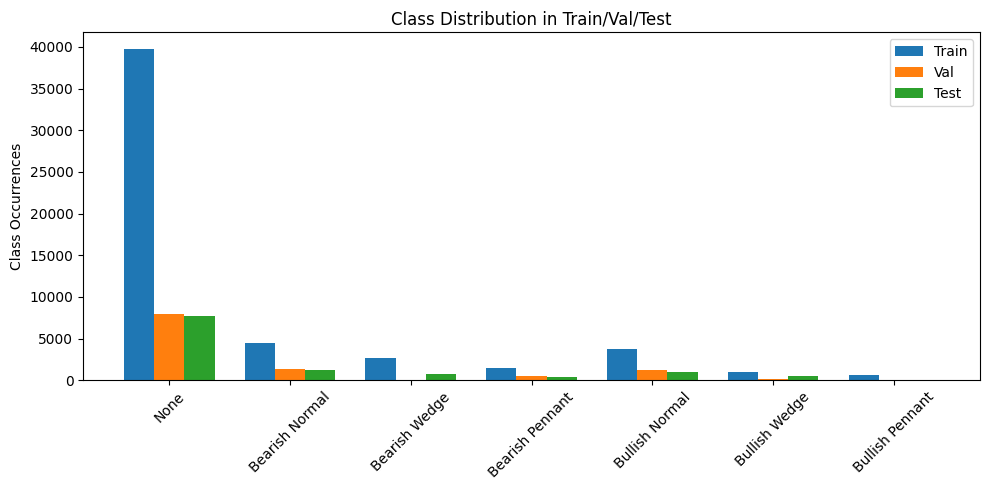

Loaded augmented (balanced) sequence data: (720, 256, 4) (720, 256)


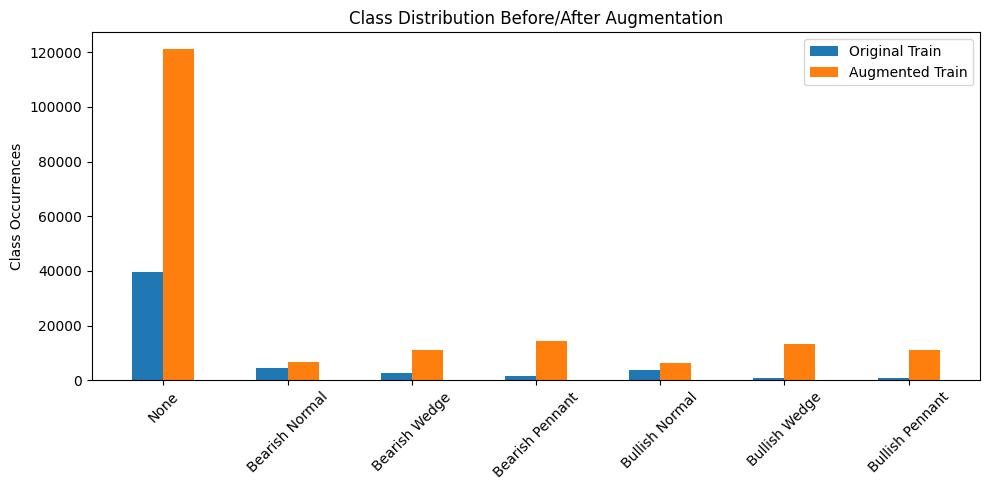

In [5]:
# --- Visualize Class Imbalance ---
import collections

# Count class occurrences in training, validation, and test sets
def count_classes(y_data, label_names):
    counter = collections.Counter()
    for seq in y_data:
        counter.update(seq.tolist())
    # Map to label names
    return {label_names.get(k, k): v for k, v in counter.items()}

# Load val and test data
X_val = np.load(config.data_dir / "X_val.npy")
Y_val = np.load(config.data_dir / "Y_val.npy")
X_test = np.load(config.data_dir / "X_test.npy")
Y_test = np.load(config.data_dir / "Y_test.npy")

train_counts = count_classes(Y_train, label_names)
val_counts = count_classes(Y_val, label_names)
test_counts = count_classes(Y_test, label_names)

# Plot class distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bar_width = 0.25
labels = list(label_names.values())
indices = np.arange(len(labels))

ax.bar(indices - bar_width, [train_counts.get(l, 0) for l in labels], width=bar_width, label='Train')
ax.bar(indices, [val_counts.get(l, 0) for l in labels], width=bar_width, label='Val')
ax.bar(indices + bar_width, [test_counts.get(l, 0) for l in labels], width=bar_width, label='Test')

ax.set_xticks(indices)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel('Class Occurrences')
ax.set_title('Class Distribution in Train/Val/Test')
ax.legend()
plt.tight_layout()
plt.show()

# --- Visualize Augmentation Process ---
# Try to load augmented data if available
import glob

def try_load_augmented(name):
    files = glob.glob(str(config.data_dir / f"{name}_balanced.npy"))
    if files:
        return np.load(files[0])
    return None

X_seq_bal = try_load_augmented("X_seq")
Y_seq_bal = try_load_augmented("Y_seq")

if X_seq_bal is not None and Y_seq_bal is not None:
    print("Loaded augmented (balanced) sequence data:", X_seq_bal.shape, Y_seq_bal.shape)
    # Count classes in augmented data
    aug_counts = count_classes(Y_seq_bal, label_names)
    # Plot before/after augmentation
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.bar(indices - bar_width/2, [train_counts.get(l, 0) for l in labels], width=bar_width, label='Original Train')
    ax.bar(indices + bar_width/2, [aug_counts.get(l, 0) for l in labels], width=bar_width, label='Augmented Train')
    ax.set_xticks(indices)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_ylabel('Class Occurrences')
    ax.set_title('Class Distribution Before/After Augmentation')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No augmented (balanced) sequence data found.")

# Summary and Interpretation

- The plots above show the class imbalance in the original training, validation, and test sets.
- The augmentation process (if available) is visualized by comparing the class distribution before and after balancing.
- This helps to understand how augmentation affects the dataset and whether it achieves a more balanced class distribution for training.

You can further analyze the effect of augmentation by training models on both the original and augmented datasets and comparing their performance.

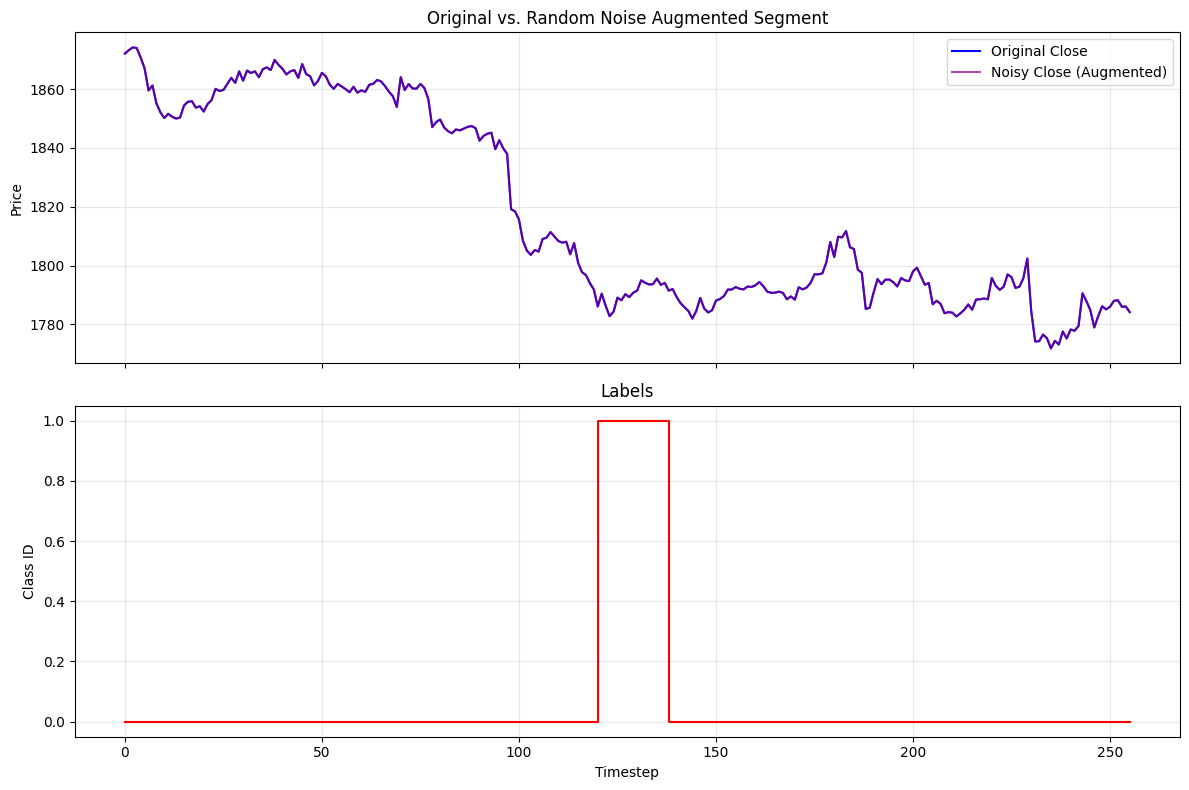

In [8]:
# --- Visualize Random Noise Augmentation on a Single Segment ---
# This cell visualizes the effect of adding random noise as augmentation to a single segment.

# Function to add random Gaussian noise to a segment
def add_random_noise(segment, noise_std=0.01):
    noisy = segment.copy()
    noise = np.random.normal(0, noise_std, size=segment.shape)
    noisy += noise
    return noisy

# Pick a segment to visualize
idx = 0  # You can change this index to visualize other segments
noise_std = 0.01  # You can adjust the noise level

X_orig = X_train[idx]
Y_orig = Y_train[idx]
X_noisy = add_random_noise(X_orig, noise_std=noise_std)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axs[0].plot(X_orig[:, 3], label='Original Close', color='blue')
axs[0].plot(X_noisy[:, 3], label='Noisy Close (Augmented)', color='purple', alpha=0.7)
axs[0].set_title('Original vs. Random Noise Augmented Segment')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

axs[1].plot(Y_orig, label='Label', color='red', drawstyle='steps-post')
axs[1].set_title('Labels')
axs[1].set_ylabel('Class ID')
axs[1].set_xlabel('Timestep')
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()